In [41]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import utide
import matplotlib.dates as mdates
from scipy import stats
import matplotlib.pyplot as plt # plotting tool

In [42]:
#  read TG data from a location csv file

#    """combine all files with same TG ID
#    Parameters:
#    ============
#        ID: str
#            Location of TG to combine data
#    Returns:
#    ===========
#        combined_data: pandas Dataframe

def readData(fpath):
    data = pd.read_csv(fpath,header=None,delimiter=',',names=['datetimes','sen','qc'],parse_dates={'datetime':[0]},index_col='datetime')
    return data

def readTG(ID):
    fp_R = glob.glob(f'/Volumes/RB/WORK/RAW_TG_DATA/1m_processed/{ID}_*_Rad.csv',recursive = True)
    df_R = pd.concat([readData(f) for f in fp_R])
    df_R.rename(columns = {'sen':'rad', 'qc':'qcr'}, inplace = True)
    fp_P = glob.glob(f'/Volumes/RB/WORK/RAW_TG_DATA/1m_processed/{ID}_*_Prs.csv',recursive = True)
    df_P = pd.concat([readData(f) for f in fp_P])
    df_P.rename(columns = {'sen':'prs', 'qc':'qcp'}, inplace = True)
    fp_E = glob.glob(f'/Volumes/RB/WORK/RAW_TG_DATA/1m_processed/{ID}_*_Enc.csv',recursive = True)
    df_E = pd.concat([readData(f) for f in fp_E])
    df_E.rename(columns = {'sen':'enc', 'qc':'qce'}, inplace = True)
    df   = pd.concat([df_R,df_P,df_E], axis=1)
    
    return (ID,df.asfreq(freq='min'))

In [43]:
ID,TG   = readTG('AerialBay')

In [44]:
TG.head()

,rad,qcr,prs,qcp,enc,qce
datetime,,,,,,
2010-10-08 05:01:00,2051.0,1.0,2119.0,1.0,2118.0,1.0
2010-10-08 05:02:00,2044.0,1.0,2111.0,1.0,2109.0,1.0
2010-10-08 05:03:00,2040.0,1.0,2103.0,1.0,2102.0,1.0
2010-10-08 05:04:00,2028.0,1.0,2095.0,1.0,2094.0,1.0
2010-10-08 05:05:00,2026.0,1.0,2085.0,1.0,2084.0,1.0


<AxesSubplot:xlabel='datetime'>

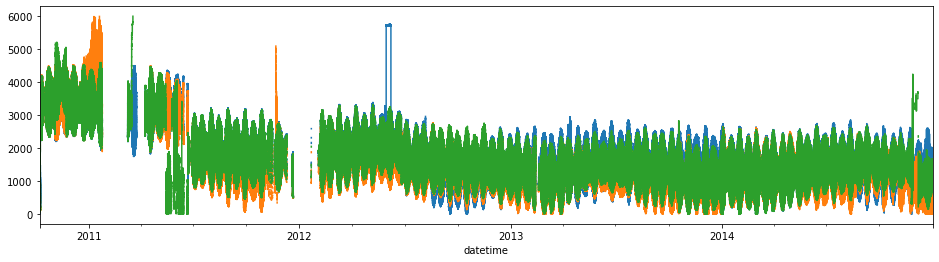

In [69]:
TG['rad'].loc[(TG['qcr']==1)].asfreq(freq='min').plot(figsize=(16,4))
TG['prs'].loc[(TG['qcp']==1)].asfreq(freq='min').plot()
TG['enc'].loc[(TG['qce']==1)].asfreq(freq='min').plot()
#dff.plot(figsize=(16,4))

In [54]:
# create a function to analyse Tide using U-Tide
def Tide_analyse(Sensor,std,edt,lat):
    dat  = Sensor.loc[std:edt]
    time = mdates.date2num(dat.index.to_pydatetime())
    coef = utide.solve(time, dat.values,
                       lat=lat,
                       phase='Greenwich',
                       constit='auto',
                       method='ols',  # {'ols', 'robust'}, Solve with ordinary least squares, or with a robust algorithm.
                       conf_int='MC') # {'linear', 'MC', 'none'}, If not 'none' (string), calculate linearized confidence
                                      # intervals, or use a Monte-Carlo simulation.
    tide = utide.reconstruct(time, coef)
    return (dat,tide,coef)

In [56]:
fp  = dff.loc["01-Sep-2013"].first_valid_index()
lp  = dff.loc["31-Dec-2013"].last_valid_index()
RAD,tideR,coefR = Tide_analyse(dff,fp,lp,20.26)

solve: matrix prep ... solution ... done.
prep/calcs ... done.


In [68]:
coefR['A']
#plt.plot(coefR.A)

array([6.77273258e+02, 3.38681047e+02, 1.27844026e+02, 1.21618821e+02,
       4.70644110e+01, 1.63891665e+01, 1.58407773e+01, 1.38004238e+01,
       8.90007977e+00, 8.86697639e+00, 7.34017616e+00, 5.71216651e+00,
       5.26145013e+00, 4.98463412e+00, 3.80203197e+00, 3.39054056e+00,
       3.20525496e+00, 2.97905617e+00, 2.58884528e+00, 2.20348115e+00,
       1.85887490e+00, 1.50249219e+00, 1.47408993e+00, 1.31033470e+00,
       1.28476022e+00, 1.25145690e+00, 1.23597116e+00, 1.04719927e+00,
       8.33534567e-01, 8.09752196e-01, 7.91324075e-01, 7.84068929e-01,
       7.45399699e-01, 3.94614493e-01, 3.61931166e-01])

<AxesSubplot:xlabel='datetime'>

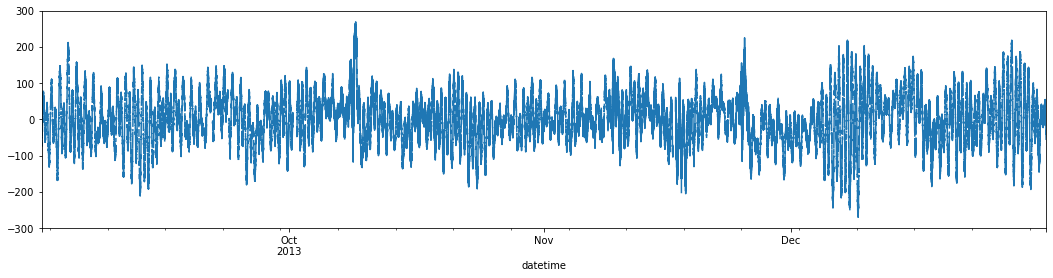

In [70]:

ra=(RAD - tideR.h)
ra.plot(figsize=(18,4),ylim=(-300,300))